In [75]:
import autograd.numpy as np
from autograd.numpy import linalg
from autograd.numpy.random import poisson, normal, multivariate_normal
from autograd import grad
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import emcee as mc
import george as ge
from george.metrics import Metric

def neg_log_like_PGP(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    #t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = 0.
    for i in range(N):
        t3 += ni[i] * np.log(mu[i] + s[i])
        t3 -= (mu[i] + s[i])
    result =  t2 + t3 #+ t1 #t1 breaks it for some reason
    if not(np.isfinite(result)):
        return np.infty
    else:
        return -result
    
neg_log_like_PGP_grad = grad(neg_log_like_PGP)

def true_mu(x):
    return (1./np.log(x+1))

def y_model(x):
    return 1./(np.power(x+.3,2))

def y_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def y_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return y_opt(x, params)
    
class mean_model(object):
    def __init__(self, f, params):
        self.f = f
        self.params = params
        self.frozen = True
    def get_value(self, x):
        return self.f(x, self.params)
    def freeze_all_parameters(self):
        self.frozen = True

'''
def kernel_func_exp(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result
        
expkernel = george.kernels.PythonKernel(kernel_func_exp, pars= [5., .5])
'''


'\ndef kernel_func_exp(x1,x2, params):\n    A = params[0]\n    l = params[1]\n\n    result = A * np.exp(-np.power((x1-x2),2)/(l**2))\n    return result\n        \nexpkernel = george.kernels.PythonKernel(kernel_func_exp, pars= [5., .5])\n'

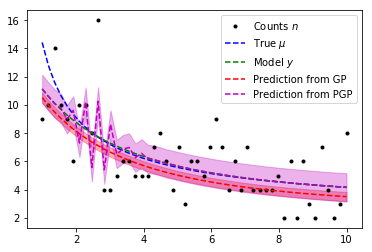

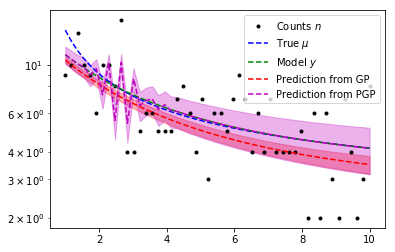

In [83]:
#initialization
N = 50
scale = 10.
params_test = [10*scale, 6., .3, 0.]
t = np.linspace(1, 10,N)
mu_test = scale* true_mu(t)

#generating poisson distributed data
n_test = poisson(mu_test)
n_err = np.sqrt(n_test)

#optimizing model parameters
popt, pcov = curve_fit(y_preopt, t, n_test, p0=[params_test])
params_test = popt
model_test = y_opt(t, params_test)

#generating kernel/gp objects
kernel_test = ge.kernels.CosineKernel(5.0)
mean_test = mean_model(y_opt, params_test)
gp_test = ge.GP(kernel = kernel_test, fit_kernel=False, mean=mean_test, fit_mean=False)
gp_test.compute(t, yerr=n_err)

#generating predictive distribution
n_pred, n_cov_array = gp_test.predict(n_test, t)
delta_n_pred = np.sqrt(np.diag(n_cov_array))

s_test = np.zeros(N)
cov = gp.get_matrix(t)

soln = minimize(neg_log_like_PGP, model_test,  method="L-BFGS-B", args = (s_test, n_test, model, cov))
mu_pred = soln.x
delta_mu_pred = np.diag(soln.hess_inv.matmat(np.eye(N)))


mu_pred_low = mu_pred-delta_mu_pred
n_pred_low = n_pred-delta_n_pred
n_pred_safe = n_pred
lowbound = 1e-2
for i in range(N):
    if mu_pred_low[i]<lowbound:
        mu_pred_low[i] = lowbound
    if n_pred_low[i]<lowbound:
        n_pred_low[i] = lowbound
    if n_pred_safe[i]<lowbound:
        n_pred_safe[i] = lowbound
        
#plotting results
plt.figure()
plt.plot(t, n_test, 'k.', label = "Counts $n$")
plt.plot(t, mu_test, 'b--', label = "True $\mu$")
plt.plot(t, model_test, 'g--', label = "Model $y$")
plt.plot(t, n_pred, 'r--', label = "Prediction from GP")
plt.fill_between(t, n_pred+delta_n_pred, n_pred-delta_n_pred, color = 'r', alpha=0.3, edgecolor="none")
plt.plot(t, mu_pred, 'm--', label = "Prediction from PGP")
plt.fill_between(t, mu_pred+delta_mu_pred, mu_pred-delta_mu_pred, color = 'm', alpha=0.3, edgecolor="none")
plt.legend(loc="upper right")

plt.figure()
plt.yscale('log')
plt.plot(t, n_test, 'k.', label = "Counts $n$")
plt.plot(t, mu_test, 'b--', label = "True $\mu$")
plt.plot(t, model_test, 'g--', label = "Model $y$")
plt.plot(t, n_pred_safe, 'r--', label = "Prediction from GP")
plt.fill_between(t, n_pred+delta_n_pred, n_pred_low, color = 'r', alpha=0.3, edgecolor="none")
plt.plot(t, mu_pred, 'm--', label = "Prediction from PGP")
plt.fill_between(t, mu_pred+delta_mu_pred, mu_pred_low, color = 'm', alpha=0.3, edgecolor="none")
plt.legend(loc="upper right")


plt.show()

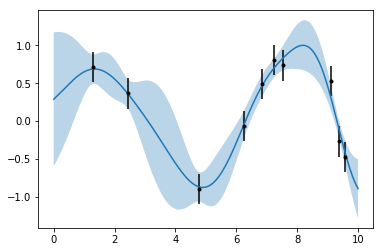

In [66]:
# Generate some fake noisy data.
x = 10 * np.sort(np.random.rand(10))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

# Set up the Gaussian process.
kernel = ge.kernels.ExpSquaredKernel(1.0)
gp = ge.GP(kernel)

# Pre-compute the factorization of the matrix.
gp.compute(x, yerr)

t = np.linspace(0, 10, 500)
mu, cov = gp.predict(y, t)
std = np.sqrt(np.diag(cov))

plt.errorbar(x, y, yerr=yerr, fmt='k.')
plt.plot(t, mu)
plt.fill_between(t, mu+std, mu-std, alpha = 0.3)